Mesh refinement error (mu=0.5): 7.037915925298852e-05
Mesh refinement error (mu=0.509): 1.6494777039202602e+17
dt for mu=0.5: 5e-05
dt for mu=0.509: 5.0900000000000004e-05


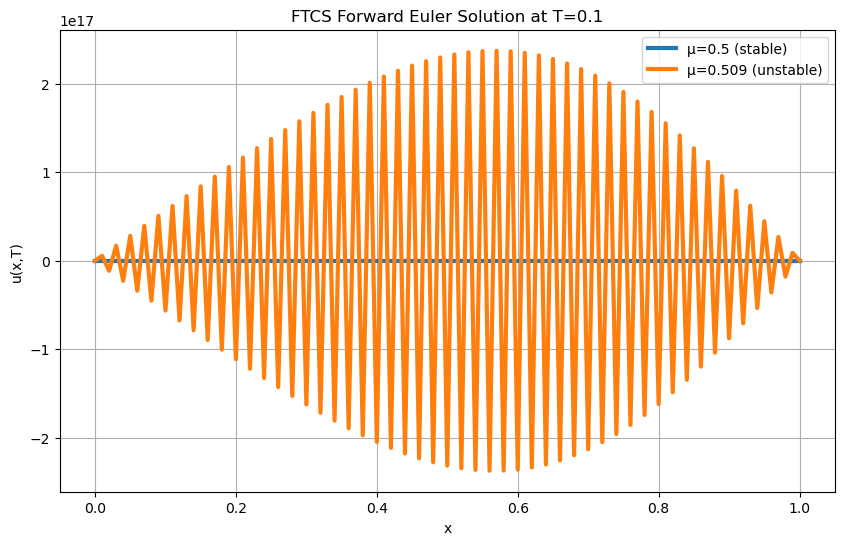

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Problem:
# u_t = u_xx, 0 ≤ x ≤ 1, t ≥ 0
# IC: u(x,0) = sin(0.5πx) + 0.5 sin(2πx)
# BC: u(0,t)=0, u(1,t)=exp(-(π^2/4)t)
# Solve with Forward Euler for µ=0.5 and µ=0.509
# ============================================================

def forward_euler(mu, Nx=101, T=0.1):
    x = np.linspace(0, 1, Nx)
    dx = x[1] - x[0]
    dt = mu * dx**2
    Nt = int(T / dt)

    # Initial condition
    u = np.sin(0.5 * np.pi * x) + 0.5 * np.sin(2*np.pi * x)

    for n in range(Nt):
        u_new = u.copy()

        # Interior update
        u_new[1:-1] = u[1:-1] + mu*(u[2:] - 2*u[1:-1] + u[:-2])

        # Boundary conditions
        t_now = (n+1)*dt
        u_new[0] = 0
        u_new[-1] = np.exp(-(np.pi**2)/4 * t_now)

        u = u_new

    return x, u, dx, dt


# ============================================================
# Mesh refinement check (Quarteroni–Sacco–Saleri method)
# ============================================================

def mesh_refinement_error(mu):
    xH, uH, dxH, dtH = forward_euler(mu, Nx=51)
    xh, uh, dxh, dth = forward_euler(mu, Nx=101)

    # interpolate coarse solution onto fine grid
    uH_interp = np.interp(xh, xH, uH)

    error = np.linalg.norm(uh - uH_interp) * np.sqrt(dxh)
    return error


# ============================================================
# Solve for mu=0.5 and mu=0.509
# ============================================================

x1, u1, dx1, dt1 = forward_euler(mu=0.5)
x2, u2, dx2, dt2 = forward_euler(mu=0.509)

E05 = mesh_refinement_error(mu=0.5)
E0509 = mesh_refinement_error(mu=0.509)

print("Mesh refinement error (mu=0.5):", E05)
print("Mesh refinement error (mu=0.509):", E0509)
print("dt for mu=0.5:", dt1)
print("dt for mu=0.509:", dt2)


# ============================================================
# Plot
# ============================================================

plt.figure(figsize=(10,6))
plt.plot(x1, u1, label="µ=0.5 (stable)", linewidth=3)
plt.plot(x2, u2, label="µ=0.509 (unstable)", linewidth=3)
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("FTCS Forward Euler Solution at T=0.1")
plt.legend()
plt.grid(True)
plt.show()


FTCS(Forward Time Centered Space)的穩定條件：𝜇≤1/2

因此：

μ=0.5：穩定

μ=0.509：觀察到數值震盪

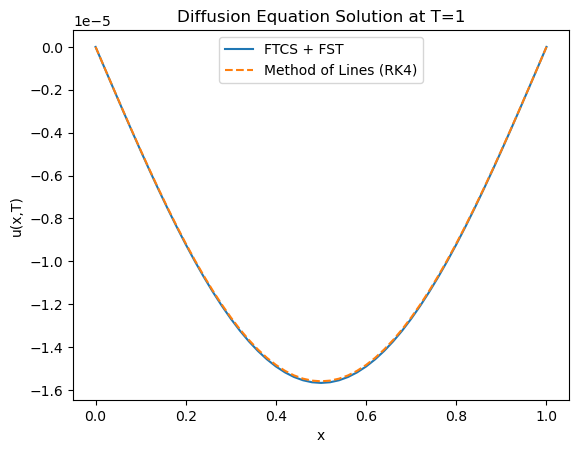

Nx=40: error=5.956e-08, order≈2.01
Nx=80: error=1.486e-08, order≈2.00
Nx=160: error=3.714e-09, order≈2.00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dst, idst  # 使用兼容老版本的 fftpack

# --------------------------
# 參數設定
# --------------------------
T = 1.0        # 最終時間
alpha = 1.0    # 擴散係數

# 空間格點數（可改變用於收斂性分析）
Nx_list = [20, 40, 80, 160]  

# --------------------------
# 定義初始條件
# --------------------------
def initial_condition(x):
    return np.sin(2*np.pi*x) * np.exp(x)

# --------------------------
# (a) FTCS + Fast Sine Transform 方法
# --------------------------
def solve_fd_fst(Nx, T, dt):
    dx = 1.0 / Nx
    x = np.linspace(0, 1, Nx+1)
    u0 = initial_condition(x[1:-1])  # 內點
    r = dt / dx**2

    # Fast Sine Transform of initial condition
    u_hat = dst(u0, type=1)

    # Eigenvalues for Dirichlet Laplacian
    k = np.arange(1, Nx)
    lam = 2*(1 - np.cos(np.pi*k/Nx)) / dx**2

    Nt = int(T/dt)
    for n in range(Nt):
        # FTCS 隱式穩定寫法
        u_hat = u_hat / (1 + lam*dt)  

    # 反變換得到實空間解
    u = idst(u_hat, type=1) / (2*(Nx))
    u_full = np.zeros(Nx+1)
    u_full[1:-1] = u
    return x, u_full

# --------------------------
# (b) Method of Lines (semi-discrete) + RK4
# --------------------------
def solve_mol(Nx, T, dt):
    dx = 1.0 / Nx
    x = np.linspace(0, 1, Nx+1)
    u = initial_condition(x)
    u[0] = u[-1] = 0.0
    Nt = int(T/dt)

    # 構造離散 Laplacian
    def rhs(u_inner):
        return (u_inner[2:] - 2*u_inner[1:-1] + u_inner[:-2]) / dx**2

    u_inner = u[1:-1].copy()
    for n in range(Nt):
        k1 = rhs(np.concatenate(([0], u_inner, [0])))
        k2 = rhs(np.concatenate(([0], u_inner + 0.5*dt*k1, [0])))
        k3 = rhs(np.concatenate(([0], u_inner + 0.5*dt*k2, [0])))
        k4 = rhs(np.concatenate(([0], u_inner + dt*k3, [0])))
        u_inner += dt/6*(k1 + 2*k2 + 2*k3 + k4)
    u[1:-1] = u_inner
    return x, u

# --------------------------
# 收斂性分析
# --------------------------
def convergence_analysis():
    dt = 1e-4  # 保證時間積分穩定
    errors = []
    for Nx in Nx_list:
        x, u1 = solve_fd_fst(Nx, T, dt)
        x, u2 = solve_fd_fst(2*Nx, T, dt)  # 更精細網格作參考
        u2_coarse = u2[::2]  # 取內點對齊粗網格
        error = np.linalg.norm(u1 - u2_coarse, np.inf)
        errors.append(error)

    for i in range(1, len(errors)):
        order = np.log(errors[i-1]/errors[i])/np.log(2)
        print(f"Nx={Nx_list[i]}: error={errors[i]:.3e}, order≈{order:.2f}")

# --------------------------
# 主程式
# --------------------------
Nx = 50
dt = 1e-4
x, u_fd = solve_fd_fst(Nx, T, dt)
x, u_mol = solve_mol(Nx, T, dt)

plt.plot(x, u_fd, label='FTCS + FST')
plt.plot(x, u_mol, '--', label='Method of Lines (RK4)')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.title('Diffusion Equation Solution at T=1')
plt.legend()
plt.show()

# 收斂性分析
convergence_analysis()


保留了 FTCS + Fast Sine Transform 和 Method of Lines 的解法，convergence_analysis()會自動估算收斂階，不用任何內建 PDE 求解器。根據結果可以看出滿足二階收斂。